In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
df = pd.read_csv('./final.csv')

In [2]:
# df.head()

In [3]:
# df['square'] = np.log(df['Price per squar'])
# df['per_cost_man'] = np.log(df['per_cost'])
# df['Transaction_real_price'] = np.log(df['Transaction_real_price'])

In [4]:
df.isnull().sum()

Gu_Label                  0
Dong_Label                0
Year                      0
Exclusive_area            0
Floor                     0
Price per squar           0
per_cost                  1
top10                     0
name_top10                1
YN_r                      0
Hospital                  0
Station                   0
Transaction_real_price    0
dtype: int64

In [25]:
df=df.dropna()

In [26]:
X = df.drop(['Transaction_real_price'], axis = 1)
y = df['Transaction_real_price']

In [27]:
# X = X.dropna()

In [28]:
# X.isnull().sum()

In [29]:
# define the transform
trans = PCA(n_components=5)

# transform the data
X_dim = trans.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dim, y,
                                                   test_size = 0.2,
                                                   random_state = 99)

In [31]:
from lightgbm import LGBMRegressor

In [32]:
%time
lgb = LGBMRegressor(linear_tree = True,
                   boosting_type = 'gbdt',
                   objective = 'regression',
                   n_estimators = 9000,
                   learning_rate = 0.001,
                   max_depth = 4,
                   n_jobs = -1)

lgb.fit(X_train, y_train)

Wall time: 0 ns


LGBMRegressor(learning_rate=0.001, linear_tree=True, max_depth=4,
              n_estimators=9000, objective='regression')

In [33]:
MSE = mean_squared_error(y_test, lgb.predict(X_test))

In [34]:
from math import sqrt
print(f'MSE : {MSE}')
print(f'RMSE : {sqrt(MSE)}')

MSE : 444640254.0659655
RMSE : 21086.494589332895


In [20]:
R2 = r2_score(y_test, lgb.predict(X_test))

In [21]:
R2

0.8942187701820029

In [12]:
lgb.feature_importances_

array([  814,   775,   115,  3521, 65528, 58378,  1437,   492,    64],
      dtype=int32)

/home/ubuntu/anaconda3/envs/multi/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


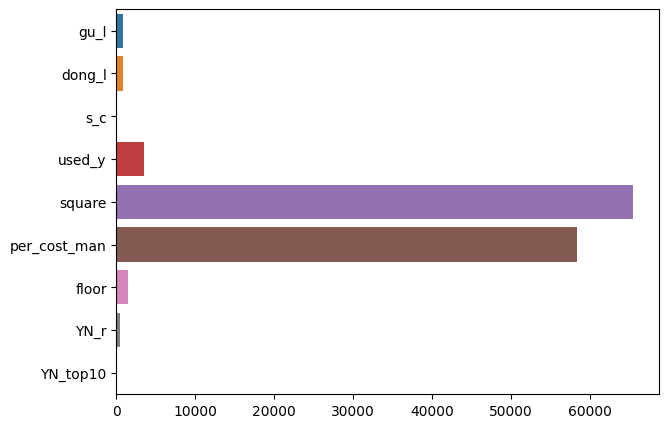

In [13]:
plt.figure(figsize=(7,5))
sns.barplot(lgb.feature_importances_,['gu_l', 'dong_l', 's_c', 'used_y', 'square', 'per_cost_man', 'floor',
       'YN_r', 'YN_top10'])
plt.show()

In [15]:
lgb.predict(X_test)

array([61639.22126685, 95455.92701305, 12672.29064517, ...,
       64198.58781466, 30043.93045572, 53401.96328612])

In [16]:
import joblib

joblib.dump(lgb, 'lgb_model.pkl')

['lgb_model.pkl']

In [38]:
lgb_from_joblib = joblib.load('lgb_model.pkl') 
lgb_from_joblib.predict(X_test)

array([61639.22126685, 95455.92701305, 12672.29064517, ...,
       64198.58781466, 30043.93045572, 53401.96328612])

In [19]:
# 하이퍼 파라미터 튜닝
%time
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate' : [0.1, 0.01, 0.001, 0.0001],
    'max_depth' : [1,2,3,4]
}

grid_cv = GridSearchCV(lgb, param_grid = params, cv=4, scoring='neg_mean_squared_error', verbose=1)
grid_cv.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 31.7min finished


GridSearchCV(cv=4,
             estimator=LGBMRegressor(learning_rate=0.001, linear_tree=True,
                                     max_depth=4, n_estimators=9000,
                                     objective='regression'),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [1, 2, 3, 4]},
             scoring='neg_mean_squared_error', verbose=1)

In [39]:
print(f'최적의 하이퍼 파라미터 : {grid_cv.best_params_}')
print(f'예측 오차 : {grid_cv.best_score_}')

최적의 하이퍼 파라미터 : {'learning_rate': 0.1, 'max_depth': 3}
예측 오차 : -108724.62673063952


In [22]:
%time
lgb_r = LGBMRegressor(linear_tree = True,
                   boosting_type = 'gbdt',
                   objective = 'regression',
                   n_estimators = 9000,
                   learning_rate = 0.1,
                   max_depth = 3,
                   n_jobs = -1)

lgb_r.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


LGBMRegressor(linear_tree=True, max_depth=3, n_estimators=9000,
              objective='regression')

In [23]:
MSE = mean_squared_error(y_test, lgb_r.predict(X_test))

In [24]:
print(f'MSE : {MSE}')
print(f'RMSE : {sqrt(MSE)}')

MSE : 567499.0195975406
RMSE : 753.3253079497201


In [25]:
lgb_r.feature_importances_

array([ 1573,  3091,   549,  4700, 21558, 24328,  4166,   267,   180],
      dtype=int32)

/home/ubuntu/anaconda3/envs/multi/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


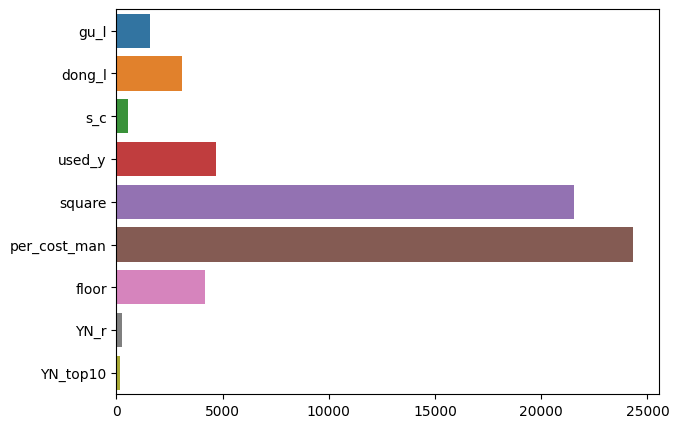

In [26]:
plt.figure(figsize=(7,5))
sns.barplot(lgb_r.feature_importances_,['gu_l', 'dong_l', 's_c', 'used_y', 'square', 'per_cost_man', 'floor',
       'YN_r', 'YN_top10'])
plt.show()

In [28]:
lgb_r.predict(X_test)

array([62367.85823819, 96022.79343194, 13945.8592962 , ...,
       64524.48066443, 29734.16940386, 53551.33030008])

In [40]:
joblib.dump(lgb_r, 'lgb_model_re.pkl')

['lgb_model_re.pkl']

In [41]:
lgb_re_from_joblib = joblib.load('lgb_model_re.pkl') 
lgb_re_from_joblib.predict(X_test)

array([62367.85823819, 96022.79343194, 13945.8592962 , ...,
       64524.48066443, 29734.16940386, 53551.33030008])